# Latinoamerica COVID vaccination
* dataset: https://www.kaggle.com/gpreda/covid-world-vaccination-progress?select=country_vaccinations.csv

## Imports

In [ ]:
! pip3 install git+https://github.com/JoaquinAmatRodrigo/skforecast@v0.1.8.1 --upgrade
! pip3 install --upgrade scikit-learn
! pip3 install statsmodels --upgrade
! pip3 install pmdarima

  Cloning https://github.com/JoaquinAmatRodrigo/skforecast (to revision v0.1.8.1) to /tmp/pip-req-build-cxdg30ld
  Running command git clone -q https://github.com/JoaquinAmatRodrigo/skforecast /tmp/pip-req-build-cxdg30ld
  Running command git checkout -q e9f125fec47e13a6ba768bf9e5c362815e84d767
  Created wheel for skforecast: filename=skforecast-0.1.8.1-cp37-none-any.whl size=25669 sha256=75da5d42c3c658a9aa079e3aeafad5c0b38f713ee68aa1dc66b114bea1059128
  Stored in directory: /tmp/pip-ephem-wheel-cache-jtf2fn3w/wheels/6e/35/85/7ac8338095a8a31e1d870230c04f48fc9f0a2c76d5130ecaf9
Successfully built skforecast
  Found existing installation: skforecast 0.1.8.1
    Uninstalling skforecast-0.1.8.1:
      Successfully uninstalled skforecast-0.1.8.1


Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.2)
Requirement already up-to-date: statsmodels in /usr/local/lib/python3.7/dist-packages (0.12.2)


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn import metrics
import statsmodels.api as sm
import pmdarima as pm
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import backtesting_forecaster_intervals
from datetime import timedelta

In [ ]:
country_vaccinations = pd.read_csv("country_vaccinations.csv")
vaccinations_manufacturer = pd.read_csv("country_vaccinations_by_manufacturer.csv")
country_population = pd.read_csv("country_population.csv")

## Exploratory Data Analysis

### country_vaccinations
Se muestra el dataset crudo y una exploración de los datos sin procesar.
Las columnas son:
* Country- país de los datos.
* Country ISO Code - código del país en formato ISO;
* Date - fecha de los datos;
* Total number of vaccinations - Valor absoluto de los habitantes innmunizados;
* Total number of people vaccinated - Personas programadas para recibir 1 o 2 dosis de la vacuna.
* Total number of people fully vaccinated - Total de personas para recibir la dosis completa.
* Daily vaccinations (raw) - Numero de vacunas para ese dia.
* Daily vaccinations - Numero de vacunas para ese dia.
* Total vaccinations per hundred - ratio (en procentaje) entre numero de vacunas y el total de poblacion para esa fecha.
* Total number of people vaccinated per hundred - ratio (in percent) entre poblacion inmunizada y el total de poblacion en esa fecha. 
* Total number of people fully vaccinated per hundred - ratio (in percent) entre poblacion totalmente inmunizada y el total de la poblacion actualizado a esa fecha. 
* Number of vaccinations per day - numero de vacunaciones por ese dia para ese pais.
* Daily vaccinations per million - ratio (in ppm) between vaccination number and total population for the current date in the country;
* Vaccines used in the country - total number of vaccines used in the country (up to date);
* Source name - source of the information (national authority, international organization, local organization etc.);
* Source website - website of the source of information;

In [ ]:
country_vaccinations.sample(5)

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
17063,Saudi Arabia,SAU,2021-01-13,NaN,NaN,NaN,NaN,15349.0,NaN,NaN,NaN,441.0,"Oxford/AstraZeneca, Pfizer/BioNTech",Saudi Health Council,https://covid19.moh.gov.sa/
10338,Kazakhstan,KAZ,2021-05-26,3009654.0,2035781.0,973873.0,44799.0,44137.0,16.03,10.84,5.19,2351.0,"QazVac, Sinopharm/HayatVax, Sputnik V",Government of Kazakhstan,https://www.coronavirus2020.kz/
6216,Ethiopia,ETH,2021-05-26,1738550.0,1738550.0,NaN,21069.0,33832.0,1.51,1.51,NaN,294.0,Oxford/AstraZeneca,Ministry of Health,https://twitter.com/FMoHealth/status/139943564...
10477,Kosovo,OWID_KOS,2021-05-11,NaN,NaN,NaN,NaN,1000.0,NaN,NaN,NaN,517.0,Oxford/AstraZeneca,Ministry of Health,https://www.facebook.com/Ministria.Shendetesis...
4014,Colombia,COL,2021-03-30,2121530.0,1858823.0,262707.0,156476.0,117389.0,4.17,3.65,0.52,2307.0,"Oxford/AstraZeneca, Pfizer/BioNTech, Sinovac",Ministry of Health,https://www.minsalud.gov.co/salud/publica/Vacu...


In [ ]:
country_vaccinations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21628 entries, 0 to 21627
Data columns (total 15 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   country                              21628 non-null  object 
 1   iso_code                             21628 non-null  object 
 2   date                                 21628 non-null  object 
 3   total_vaccinations                   12275 non-null  float64
 4   people_vaccinated                    11479 non-null  float64
 5   people_fully_vaccinated              8967 non-null   float64
 6   daily_vaccinations_raw               10187 non-null  float64
 7   daily_vaccinations                   21412 non-null  float64
 8   total_vaccinations_per_hundred       12275 non-null  float64
 9   people_vaccinated_per_hundred        11479 non-null  float64
 10  people_fully_vaccinated_per_hundred  8967 non-null   float64
 11  daily_vaccinations_per_milli

In [ ]:
country_vaccinations.describe()

,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million
count,1.227500e+04,1.147900e+04,8.967000e+03,1.018700e+04,2.141200e+04,12275.000000,11479.000000,8967.000000,21412.000000
mean,7.123137e+06,4.018807e+06,2.193614e+06,1.707464e+05,8.879945e+04,20.361753,14.217948,7.847090,3221.901877
std,3.225143e+07,1.491983e+07,9.299795e+06,8.860199e+05,5.625884e+05,27.554987,17.473412,11.907316,8202.956508
min,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,8.029300e+04,6.640100e+04,2.946100e+04,3.477000e+03,8.210000e+02,1.860000,1.725000,0.820000,352.750000
50%,5.726620e+05,4.411200e+05,2.354230e+05,1.823600e+04,5.892000e+03,8.910000,6.870000,3.230000,1615.000000
75%,2.643352e+06,1.825397e+06,9.465625e+05,7.220750e+04,3.148000e+04,28.025000,20.570000,9.600000,4485.250000
max,6.614680e+08,1.677340e+08,1.350873e+08,2.229600e+07,1.917357e+07,230.090000,116.000000,114.090000,1000000.000000


### vaccinations_manufacturer
Muestra el dataset crudo con las columnas:
* Location - pais;
* Date - Fecha;
* Vaccine - Tipo de vacuna;
* Total number of vaccinations - numero total de vacunaciones en esa fecha y tipo de vacuna.

In [ ]:
vaccinations_manufacturer.sample(5)

,location,date,vaccine,total_vaccinations
2903,Latvia,2021-01-19,Pfizer/BioNTech,16547
4411,United States,2021-02-25,Moderna,33066503
2372,Iceland,2021-05-16,Oxford/AstraZeneca,62386
775,France,2021-01-15,Pfizer/BioNTech,410185
719,Czechia,2021-05-23,Moderna,438136


In [ ]:
vaccinations_manufacturer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4685 entries, 0 to 4684
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   location            4685 non-null   object
 1   date                4685 non-null   object
 2   vaccine             4685 non-null   object
 3   total_vaccinations  4685 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 146.5+ KB


In [ ]:
vaccinations_manufacturer.describe()

,total_vaccinations
count,4.685000e+03
mean,5.796318e+06
std,1.951684e+07
min,0.000000e+00
25%,2.384700e+04
50%,2.633770e+05
75%,2.268136e+06
max,1.594120e+08


### country_population
Only need population of the countries

In [ ]:
country_population = country_population[['Country Name', '2019']]

## Mexico vaccination

In [ ]:
mexico_vaccinations = country_vaccinations[country_vaccinations['country']=="Mexico"]
mexico_vaccinations_manufacturer = vaccinations_manufacturer[vaccinations_manufacturer['location']=="Mexico"]

In [ ]:
#Mexico no esta en el registro
mexico_vaccinations_manufacturer.count()

location              0
date                  0
vaccine               0
total_vaccinations    0
dtype: int64

In [ ]:
mexico_vaccinations.shape

(159, 15)

In [ ]:
mexico_vaccinations.sample(5)

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
12551,Mexico,MEX,2021-05-13,22413285.0,14996844.0,10108593.0,426829.0,267494.0,17.38,11.63,7.84,2075.0,"CanSino, Oxford/AstraZeneca, Pfizer/BioNTech, ...",Secretary of Health,https://www.gob.mx/cms/uploads/attachment/file...
12469,Mexico,MEX,2021-02-20,1656304.0,1210886.0,445418.0,82146.0,132856.0,1.28,0.94,0.35,1030.0,"CanSino, Oxford/AstraZeneca, Pfizer/BioNTech, ...",Secretary of Health,https://www.gob.mx/cms/uploads/attachment/file...
12488,Mexico,MEX,2021-03-11,3800000.0,NaN,NaN,312000.0,160566.0,2.95,NaN,NaN,1245.0,"CanSino, Oxford/AstraZeneca, Pfizer/BioNTech, ...",Secretary of Health,https://www.gob.mx/cms/uploads/attachment/file...
12568,Mexico,MEX,2021-05-30,30293682.0,21636247.0,12390240.0,NaN,519703.0,23.50,16.78,9.61,4031.0,"CanSino, Oxford/AstraZeneca, Pfizer/BioNTech, ...",Secretary of Health,https://www.gob.mx/cms/uploads/attachment/file...
12480,Mexico,MEX,2021-03-03,2633580.0,2043941.0,589639.0,50145.0,104685.0,2.04,1.59,0.46,812.0,"CanSino, Oxford/AstraZeneca, Pfizer/BioNTech, ...",Secretary of Health,https://www.gob.mx/cms/uploads/attachment/file...


In [ ]:
mexico_vaccinations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159 entries, 12411 to 12569
Data columns (total 15 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   country                              159 non-null    object 
 1   iso_code                             159 non-null    object 
 2   date                                 159 non-null    object 
 3   total_vaccinations                   144 non-null    float64
 4   people_vaccinated                    135 non-null    float64
 5   people_fully_vaccinated              118 non-null    float64
 6   daily_vaccinations_raw               133 non-null    float64
 7   daily_vaccinations                   158 non-null    float64
 8   total_vaccinations_per_hundred       144 non-null    float64
 9   people_vaccinated_per_hundred        135 non-null    float64
 10  people_fully_vaccinated_per_hundred  118 non-null    float64
 11  daily_vaccinations_per_mil

In [ ]:
mexico_vaccinations.describe()

,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million
count,1.440000e+02,1.350000e+02,1.180000e+02,133.000000,158.000000,144.000000,135.000000,118.000000,158.000000
mean,8.207852e+06,6.243071e+06,3.273326e+06,195119.804511,186391.424051,6.365694,4.842148,2.538983,1445.645570
std,8.959870e+06,6.366370e+06,4.188680e+06,200712.115615,165156.907383,6.949130,4.937469,3.248746,1280.944497
min,2.924000e+03,2.924000e+03,1.958000e+03,311.000000,1300.000000,0.000000,0.000000,0.000000,10.000000
25%,6.929662e+05,6.317690e+05,8.619800e+04,15479.000000,21854.750000,0.537500,0.490000,0.070000,169.500000
50%,4.277110e+06,3.604420e+06,7.512210e+05,142756.000000,172765.000000,3.320000,2.800000,0.585000,1340.000000
75%,1.467953e+07,1.171538e+07,5.895777e+06,308027.000000,319693.250000,11.385000,9.085000,4.572500,2479.500000
max,3.047770e+07,2.179697e+07,1.241525e+07,921413.000000,530340.000000,23.640000,16.910000,9.630000,4113.000000


In [ ]:
#None values
mexico_vaccinations.isna().sum()

country                                 0
iso_code                                0
date                                    0
total_vaccinations                     15
people_vaccinated                      24
people_fully_vaccinated                41
daily_vaccinations_raw                 26
daily_vaccinations                      1
total_vaccinations_per_hundred         15
people_vaccinated_per_hundred          24
people_fully_vaccinated_per_hundred    41
daily_vaccinations_per_million          1
vaccines                                0
source_name                             0
source_website                          0
dtype: int64

In [ ]:
print("inicio vacunacion en Mexico:",mexico_vaccinations.date.min())
print("Actual vacunacion en Mexico:", mexico_vaccinations.date.max())

inicio vacunacion en Mexico: 2020-12-24
Actual vacunacion en Mexico: 2021-05-31


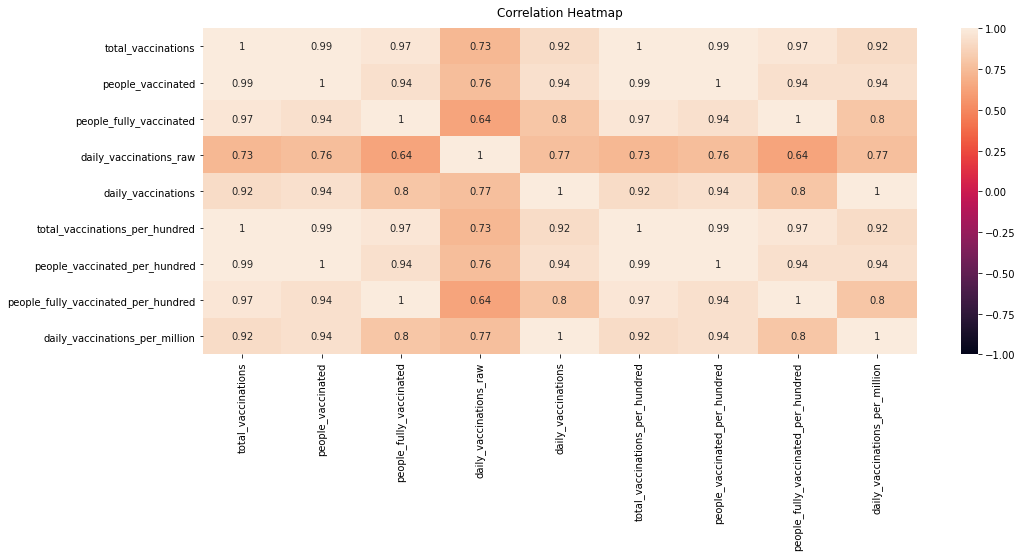

In [ ]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(mexico_vaccinations.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [ ]:
#convert date in date format and set as index.
mexico_vaccinations['date'] = pd.to_datetime(mexico_vaccinations['date'])
mexico_vaccinations.set_index('date', inplace=True)
mexico_vaccinations.head()

,country,iso_code,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
date,,,,,,,,,,,,,,
2020-12-24,Mexico,MEX,2924.0,2924.0,NaN,NaN,NaN,0.00,0.00,NaN,NaN,"CanSino, Oxford/AstraZeneca, Pfizer/BioNTech, ...",Secretary of Health,https://www.gob.mx/cms/uploads/attachment/file...
2020-12-25,Mexico,MEX,NaN,NaN,NaN,NaN,1300.0,NaN,NaN,NaN,10.0,"CanSino, Oxford/AstraZeneca, Pfizer/BioNTech, ...",Secretary of Health,https://www.gob.mx/cms/uploads/attachment/file...
2020-12-26,Mexico,MEX,NaN,NaN,NaN,NaN,1300.0,NaN,NaN,NaN,10.0,"CanSino, Oxford/AstraZeneca, Pfizer/BioNTech, ...",Secretary of Health,https://www.gob.mx/cms/uploads/attachment/file...
2020-12-27,Mexico,MEX,6824.0,6824.0,NaN,NaN,1300.0,0.01,0.01,NaN,10.0,"CanSino, Oxford/AstraZeneca, Pfizer/BioNTech, ...",Secretary of Health,https://www.gob.mx/cms/uploads/attachment/file...
2020-12-28,Mexico,MEX,9579.0,9579.0,NaN,2755.0,1664.0,0.01,0.01,NaN,13.0,"CanSino, Oxford/AstraZeneca, Pfizer/BioNTech, ...",Secretary of Health,https://www.gob.mx/cms/uploads/attachment/file...


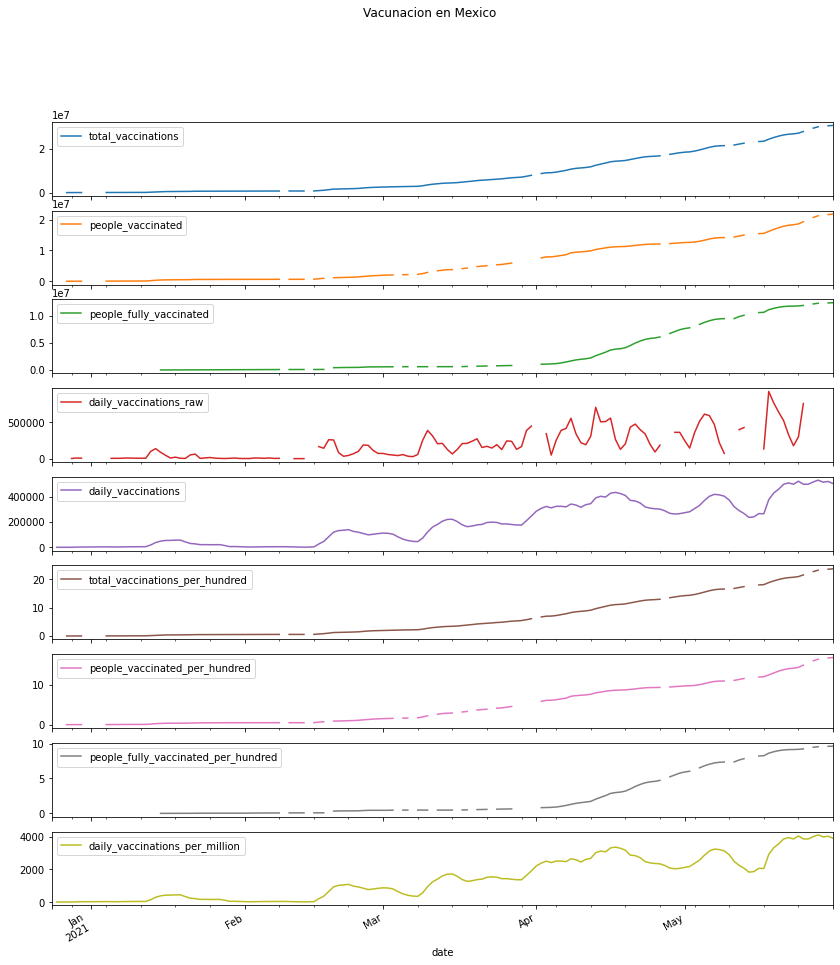

In [ ]:
#distribution
mexico_vaccinations.plot(subplots=True, figsize=(14, 16), title="Vacunacion en Mexico")
plt.legend(loc='best')

### Preprocesing data Mexico

#### Mexico: Fill nan values: Interpolation
Imputing using interpolation with different methods

#### Mexico vaccinations: daily vaccinations raw estimation

In [ ]:
# Import a scoring metric to compare methods
from sklearn.metrics import r2_score
df = pd.DataFrame(mexico_vaccinations[['daily_vaccinations','daily_vaccinations_raw']])
df = df['2020-12-28':]

df = df.assign(FillBackfill = df.daily_vaccinations_raw.fillna(value=None, method='backfill', axis=None, limit=None, downcast=None))
df = df.assign(FillFfil = df.daily_vaccinations_raw.fillna(method='ffill'))
#mean & median
df = df.assign(FillMean=df.daily_vaccinations_raw.fillna(df.daily_vaccinations_raw.mean()))
df = df.assign(FillMedian=df.daily_vaccinations_raw.fillna(df.daily_vaccinations_raw.median()))
# imputing using the rolling average and median
df = df.assign(RollingMean=df.daily_vaccinations_raw.fillna(df.daily_vaccinations_raw.rolling(24,min_periods=1,).mean()))
df = df.assign(RollingMedian=df.daily_vaccinations_raw.fillna(df.daily_vaccinations_raw.rolling(24,min_periods=1,).median()))# imputing using the median
#differents types of interpolation
df = df.assign(InterpolateLinear=df.daily_vaccinations_raw.interpolate(method='linear'))
df = df.assign(InterpolateTime=df.daily_vaccinations_raw.interpolate(method='time'))
df = df.assign(InterpolateQuadratic=df.daily_vaccinations_raw.interpolate(method='quadratic'))
df = df.assign(InterpolateCubic=df.daily_vaccinations_raw.interpolate(method='cubic'))
df = df.assign(InterpolateSLinear=df.daily_vaccinations_raw.interpolate(method='slinear'))
df = df.assign(InterpolateAkima=df.daily_vaccinations_raw.interpolate(method='akima'))
df = df.assign(InterpolatePoly5=df.daily_vaccinations_raw.interpolate(method='polynomial', order=5)) 
df = df.assign(InterpolatePoly7=df.daily_vaccinations_raw.interpolate(method='polynomial', order=7))
# df = df.assign(InterpolateSpline3=df.daily_vaccinations_raw.interpolate(method='spline', order=3))
df = df.assign(InterpolateSpline4=df.daily_vaccinations_raw.interpolate(method='spline', order=4))
df = df.assign(InterpolateSpline5=df.daily_vaccinations_raw.interpolate(method='spline', order=5))
df

,daily_vaccinations,daily_vaccinations_raw,FillBackfill,FillFfil,FillMean,FillMedian,RollingMean,RollingMedian,InterpolateLinear,InterpolateTime,InterpolateQuadratic,InterpolateCubic,InterpolateSLinear,InterpolateAkima,InterpolatePoly5,InterpolatePoly7,InterpolateSpline4,InterpolateSpline5
date,,,,,,,,,,,,,,,,,,
2020-12-28,1664.0,2755.0,2755.0,2755.0,2755.000000,2755.0,2755.000000,2755.0,2755.000000,2755.000000,2755.000000,2755.000000,2755.000000,2755.000000,2.755000e+03,2.755000e+03,2.755000e+03,2.755000e+03
2020-12-29,3121.0,8950.0,8950.0,8950.0,8950.000000,8950.0,8950.000000,8950.0,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03
2020-12-30,3679.0,6469.0,6469.0,6469.0,6469.000000,6469.0,6469.000000,6469.0,6469.000000,6469.000000,6469.000000,6469.000000,6469.000000,6469.000000,6.469000e+03,6.469000e+03,6.469000e+03,6.469000e+03
2020-12-31,3695.0,NaN,4276.0,6469.0,195119.804511,142756.0,6058.000000,6469.0,6103.500000,6103.500000,3822.969839,3774.965728,6103.500000,5825.390584,1.449360e+03,-4.800780e+03,1.374971e+03,1.449254e+03
2021-01-01,4051.0,NaN,4276.0,6469.0,195119.804511,142756.0,6058.000000,6469.0,5738.000000,5738.000000,2430.404489,2354.935894,5738.000000,5149.584928,-2.444059e+03,-1.471436e+04,-2.438158e+03,-2.444340e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-27,516226.0,NaN,621334.0,756065.0,195119.804511,142756.0,461070.294118,467788.0,666244.333333,666244.333333,798237.010959,877294.681801,666244.333333,729334.239963,1.304548e+06,1.091991e+06,1.116170e+06,1.304555e+06
2021-05-28,530340.0,621334.0,621334.0,621334.0,621334.000000,621334.0,621334.000000,621334.0,621334.000000,621334.000000,621334.000000,621334.000000,621334.000000,621334.000000,6.213340e+05,6.213340e+05,6.213340e+05,6.213340e+05
2021-05-29,514092.0,NaN,184021.0,621334.0,195119.804511,142756.0,458501.937500,447308.5,475563.000000,475563.000000,459996.994521,331753.095977,475563.000000,494257.679571,-6.308288e+05,5.044141e+05,-1.022365e+05,-6.308473e+05


In [ ]:
#check score
results = [(method, r2_score(df['daily_vaccinations'], df[method])) for method in list(df)[2:]]
results_df = pd.DataFrame(np.array(results), columns=['Method', 'R_squared'])
results_df.sort_values(by='R_squared', ascending=False)

,Method,R_squared
4,RollingMean,0.46963264142351346
5,RollingMedian,0.46457543556042324
6,InterpolateLinear,0.4361661360995859
7,InterpolateTime,0.4361661360995859
10,InterpolateSLinear,0.4361661360995859
11,InterpolateAkima,0.41426679862026106
0,FillBackfill,0.3968129404854829
1,FillFfil,0.37459493766182084
2,FillMean,0.2876555773869799
3,FillMedian,0.26347823532177683


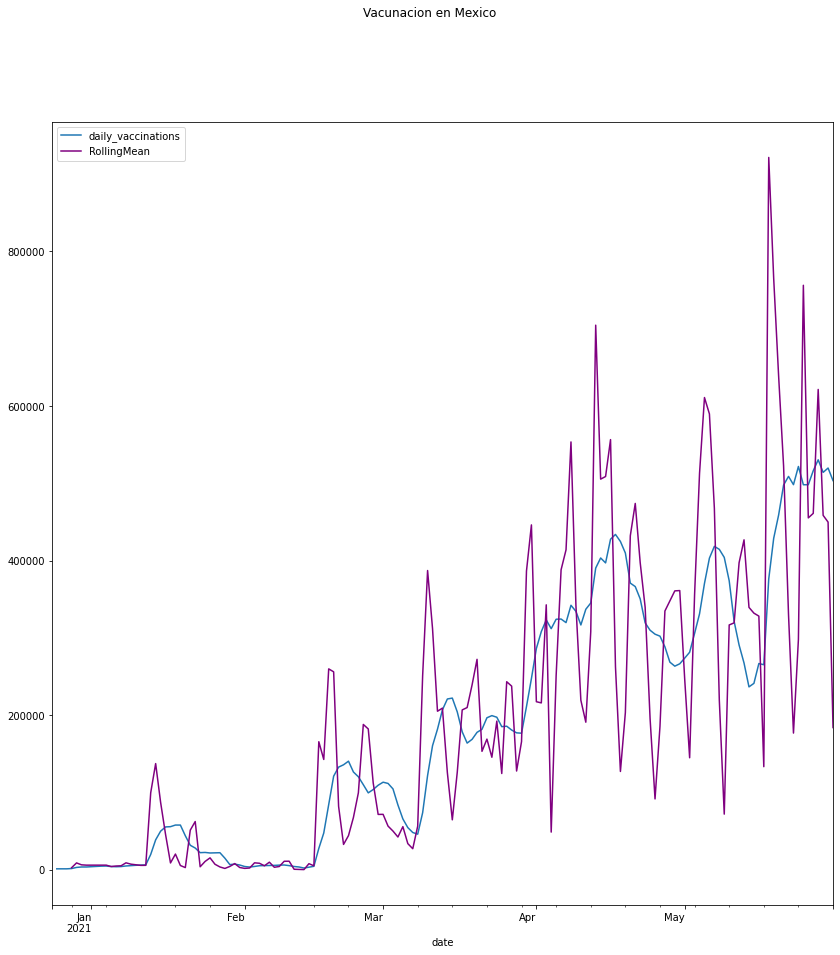

In [ ]:
#distribution
mexico_vaccinations['daily_vaccinations'].plot(subplots=True, figsize=(14, 16), title="Vacunacion en Mexico")
df['RollingMean'].plot(color='purple')
plt.legend(loc='best')

In [ ]:
#ignore raw data and use directly daily_vaccination
del mexico_vaccinations['daily_vaccinations_raw']

#### Mexico vaccinations: people fully vaccinated

In [ ]:
#people_fully_vaccinated
# Import a scoring metric to compare methods
df = pd.DataFrame(mexico_vaccinations[['people_fully_vaccinated']])
df = df.assign(FillBackfill = df.people_fully_vaccinated.fillna(value=None, method='backfill', axis=None, limit=None, downcast=None))
df = df.assign(FillFfil = df.people_fully_vaccinated.fillna(method='ffill'))
#mean & median
df = df.assign(FillMean=df.people_fully_vaccinated.fillna(df.people_fully_vaccinated.mean()))
df = df.assign(FillMedian=df.people_fully_vaccinated.fillna(df.people_fully_vaccinated.median()))
# imputing using the rolling average and median
df = df.assign(RollingMean=df.people_fully_vaccinated.fillna(df.people_fully_vaccinated.rolling(24,min_periods=1,).mean()))
df = df.assign(RollingMedian=df.people_fully_vaccinated.fillna(df.people_fully_vaccinated.rolling(24,min_periods=1,).median()))# imputing using the median
#differents types of interpolation
df = df.assign(InterpolateLinear=df.people_fully_vaccinated.interpolate(method='linear'))
df = df.assign(InterpolateTime=df.people_fully_vaccinated.interpolate(method='time'))
df = df.assign(InterpolateQuadratic=df.people_fully_vaccinated.interpolate(method='quadratic'))
df = df.assign(InterpolateCubic=df.people_fully_vaccinated.interpolate(method='cubic'))
df = df.assign(InterpolateSLinear=df.people_fully_vaccinated.interpolate(method='slinear'))
df = df.assign(InterpolateSpline3=df.people_fully_vaccinated.interpolate(method='spline', order=3))
df = df.assign(InterpolateSpline4=df.people_fully_vaccinated.interpolate(method='spline', order=4))
df = df.assign(InterpolateSpline5=df.people_fully_vaccinated.interpolate(method='spline', order=5))
df

,people_fully_vaccinated,FillBackfill,FillFfil,FillMean,FillMedian,RollingMean,RollingMedian,InterpolateLinear,InterpolateTime,InterpolateQuadratic,InterpolateCubic,InterpolateSLinear,InterpolateSpline3,InterpolateSpline4,InterpolateSpline5
date,,,,,,,,,,,,,,,
2020-12-24,NaN,1958.0,NaN,3.273326e+06,751221.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-25,NaN,1958.0,NaN,3.273326e+06,751221.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-26,NaN,1958.0,NaN,3.273326e+06,751221.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-27,NaN,1958.0,NaN,3.273326e+06,751221.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-28,NaN,1958.0,NaN,3.273326e+06,751221.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-27,12204779.0,12204779.0,12204779.0,1.220478e+07,12204779.0,1.220478e+07,12204779.0,12204779.0,12204779.0,1.220478e+07,1.220478e+07,12204779.0,1.220478e+07,1.220478e+07,1.220478e+07
2021-05-28,12320589.0,12320589.0,12320589.0,1.232059e+07,12320589.0,1.232059e+07,12320589.0,12320589.0,12320589.0,1.232059e+07,1.232059e+07,12320589.0,1.232059e+07,1.232059e+07,1.232059e+07
2021-05-29,NaN,12390240.0,12320589.0,3.273326e+06,751221.0,1.082887e+07,11131624.0,12355414.5,12355414.5,1.237145e+07,1.237299e+07,12355414.5,1.237299e+07,1.237771e+07,1.237736e+07


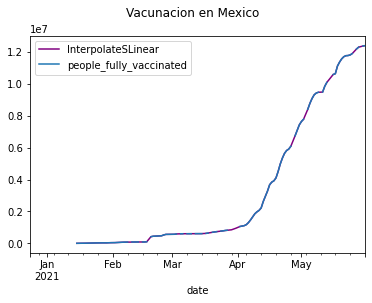

In [ ]:
#distribution
df['InterpolateSLinear'].plot(color='purple')
mexico_vaccinations['people_fully_vaccinated'].plot(subplots=True, figsize=(24, 32), title="Vacunacion en Mexico")
plt.legend(loc='best')
mexico_vaccinations = mexico_vaccinations.assign(people_fully_vaccinated=df['InterpolateSLinear'])

#### Mexico: Total vaccinations

In [ ]:
#total_vaccinations
# Import a scoring metric to compare methods
df = pd.DataFrame(mexico_vaccinations[['total_vaccinations']])
df = df.assign(FillBackfill = df.total_vaccinations.fillna(value=None, method='backfill', axis=None, limit=None, downcast=None))
df = df.assign(FillFfil = df.total_vaccinations.fillna(method='ffill'))
#mean & median
df = df.assign(FillMean=df.total_vaccinations.fillna(df.total_vaccinations.mean()))
df = df.assign(FillMedian=df.total_vaccinations.fillna(df.total_vaccinations.median()))
# imputing using the rolling average and median
df = df.assign(RollingMean=df.total_vaccinations.fillna(df.total_vaccinations.rolling(24,min_periods=1,).mean()))
df = df.assign(RollingMedian=df.total_vaccinations.fillna(df.total_vaccinations.rolling(24,min_periods=1,).median()))# imputing using the median
#differents types of interpolation
df = df.assign(InterpolateLinear=df.total_vaccinations.interpolate(method='linear'))
df = df.assign(InterpolateTime=df.total_vaccinations.interpolate(method='time'))
df = df.assign(InterpolateQuadratic=df.total_vaccinations.interpolate(method='quadratic'))
df = df.assign(InterpolateCubic=df.total_vaccinations.interpolate(method='cubic'))
df = df.assign(InterpolateSLinear=df.total_vaccinations.interpolate(method='slinear'))
df = df.assign(InterpolateSpline3=df.total_vaccinations.interpolate(method='spline', order=3))
df = df.assign(InterpolateSpline4=df.total_vaccinations.interpolate(method='spline', order=4))
df = df.assign(InterpolateSpline5=df.total_vaccinations.interpolate(method='spline', order=5))
df

,total_vaccinations,FillBackfill,FillFfil,FillMean,FillMedian,RollingMean,RollingMedian,InterpolateLinear,InterpolateTime,InterpolateQuadratic,InterpolateCubic,InterpolateSLinear,InterpolateSpline3,InterpolateSpline4,InterpolateSpline5
date,,,,,,,,,,,,,,,
2020-12-24,2924.0,2924.0,2924.0,2.924000e+03,2924.0,2.924000e+03,2924.0,2924.0,2924.0,2.924000e+03,2.924000e+03,2924.0,2.924000e+03,2.924000e+03,2.924000e+03
2020-12-25,NaN,6824.0,2924.0,8.207852e+06,4277110.0,2.924000e+03,2924.0,4224.0,4224.0,4.048179e+03,8.869320e+03,4224.0,8.869212e+03,1.882783e+04,8.214324e+04
2020-12-26,NaN,6824.0,2924.0,8.207852e+06,4277110.0,2.924000e+03,2924.0,5524.0,5524.0,5.348179e+03,8.378380e+03,5524.0,8.378300e+03,1.300084e+04,3.596327e+04
2020-12-27,6824.0,6824.0,6824.0,6.824000e+03,6824.0,6.824000e+03,6824.0,6824.0,6824.0,6.824000e+03,6.824000e+03,6824.0,6.824000e+03,6.824000e+03,6.824000e+03
2020-12-28,9579.0,9579.0,9579.0,9.579000e+03,9579.0,9.579000e+03,9579.0,9579.0,9579.0,9.579000e+03,9.579000e+03,9579.0,9.579000e+03,9.579000e+03,9.579000e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-27,29239997.0,29239997.0,29239997.0,2.924000e+07,29239997.0,2.924000e+07,29239997.0,29239997.0,29239997.0,2.924000e+07,2.924000e+07,29239997.0,2.924000e+07,2.924000e+07,2.924000e+07
2021-05-28,29861331.0,29861331.0,29861331.0,2.986133e+07,29861331.0,2.986133e+07,29861331.0,29861331.0,29861331.0,2.986133e+07,2.986133e+07,29861331.0,2.986133e+07,2.986133e+07,2.986133e+07
2021-05-29,NaN,30293682.0,29861331.0,8.207852e+06,4277110.0,2.444336e+07,24223297.0,30077506.5,30077506.5,3.015630e+07,3.016737e+07,30077506.5,3.016737e+07,3.020778e+07,3.031622e+07


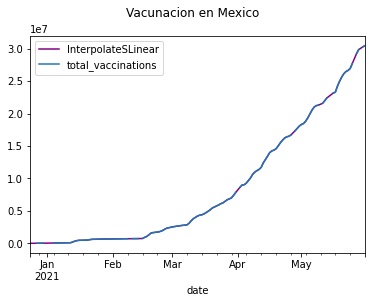

In [ ]:
#distribution
df['InterpolateSLinear'].plot(color='purple')
mexico_vaccinations['total_vaccinations'].plot(subplots=True, figsize=(24, 32), title="Vacunacion en Mexico")
plt.legend(loc='best')
mexico_vaccinations = mexico_vaccinations.assign(total_vaccinations=df['InterpolateSLinear'])

#### Mexico vaccination: people vaccinated

In [ ]:
#people_vaccinated
# Import a scoring metric to compare methods
df = pd.DataFrame(mexico_vaccinations[['people_vaccinated']])
df = df.assign(FillBackfill = df.people_vaccinated.fillna(value=None, method='backfill', axis=None, limit=None, downcast=None))
df = df.assign(FillFfil = df.people_vaccinated.fillna(method='ffill'))
#mean & median
df = df.assign(FillMean=df.people_vaccinated.fillna(df.people_vaccinated.mean()))
df = df.assign(FillMedian=df.people_vaccinated.fillna(df.people_vaccinated.median()))
# imputing using the rolling average and median
df = df.assign(RollingMean=df.people_vaccinated.fillna(df.people_vaccinated.rolling(24,min_periods=1,).mean()))
df = df.assign(RollingMedian=df.people_vaccinated.fillna(df.people_vaccinated.rolling(24,min_periods=1,).median()))# imputing using the median
#differents types of interpolation
df = df.assign(InterpolateLinear=df.people_vaccinated.interpolate(method='linear'))
df = df.assign(InterpolateTime=df.people_vaccinated.interpolate(method='time'))
df = df.assign(InterpolateQuadratic=df.people_vaccinated.interpolate(method='quadratic'))
df = df.assign(InterpolateCubic=df.people_vaccinated.interpolate(method='cubic'))
df = df.assign(InterpolateSLinear=df.people_vaccinated.interpolate(method='slinear'))
df = df.assign(InterpolateSpline3=df.people_vaccinated.interpolate(method='spline', order=3))
df = df.assign(InterpolateSpline4=df.people_vaccinated.interpolate(method='spline', order=4))
df = df.assign(InterpolateSpline5=df.people_vaccinated.interpolate(method='spline', order=5))
df

,people_vaccinated,FillBackfill,FillFfil,FillMean,FillMedian,RollingMean,RollingMedian,InterpolateLinear,InterpolateTime,InterpolateQuadratic,InterpolateCubic,InterpolateSLinear,InterpolateSpline3,InterpolateSpline4,InterpolateSpline5
date,,,,,,,,,,,,,,,
2020-12-24,2924.0,2924.0,2924.0,2.924000e+03,2924.0,2.924000e+03,2924.0,2924.0,2924.0,2.924000e+03,2.924000e+03,2924.0,2.924000e+03,2.924000e+03,2.924000e+03
2020-12-25,NaN,6824.0,2924.0,6.243071e+06,3604420.0,2.924000e+03,2924.0,4224.0,4224.0,4.048179e+03,8.869320e+03,4224.0,8.869209e+03,1.882785e+04,3.248930e+04
2020-12-26,NaN,6824.0,2924.0,6.243071e+06,3604420.0,2.924000e+03,2924.0,5524.0,5524.0,5.348179e+03,8.378380e+03,5524.0,8.378298e+03,1.300085e+04,1.804450e+04
2020-12-27,6824.0,6824.0,6824.0,6.824000e+03,6824.0,6.824000e+03,6824.0,6824.0,6824.0,6.824000e+03,6.824000e+03,6824.0,6.824000e+03,6.824000e+03,6.824000e+03
2020-12-28,9579.0,9579.0,9579.0,9.579000e+03,9579.0,9.579000e+03,9579.0,9579.0,9579.0,9.579000e+03,9.579000e+03,9579.0,9.579000e+03,9.579000e+03,9.579000e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-27,20721248.0,20721248.0,20721248.0,2.072125e+07,20721248.0,2.072125e+07,20721248.0,20721248.0,20721248.0,2.072125e+07,2.072125e+07,20721248.0,2.072125e+07,2.072125e+07,2.072125e+07
2021-05-28,21259657.0,21259657.0,21259657.0,2.125966e+07,21259657.0,2.125966e+07,21259657.0,21259657.0,21259657.0,2.125966e+07,2.125966e+07,21259657.0,2.125966e+07,2.125966e+07,2.125966e+07
2021-05-29,NaN,21636247.0,21259657.0,6.243071e+06,3604420.0,1.661910e+07,16173646.0,21447952.0,21447952.0,2.151543e+07,2.152474e+07,21447952.0,2.152474e+07,2.155896e+07,2.159549e+07


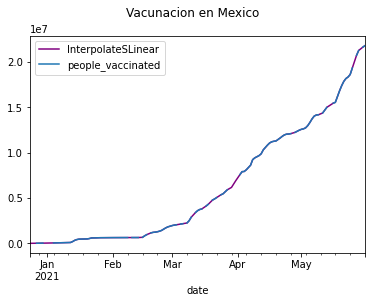

In [ ]:
#distribution
df['InterpolateSLinear'].plot(color='purple')
mexico_vaccinations['people_vaccinated'].plot(subplots=True, figsize=(24, 32), title="Vacunacion en Mexico")
plt.legend(loc='best')
mexico_vaccinations = mexico_vaccinations.assign(people_vaccinated=df['InterpolateSLinear'])

#### Mexico vaccination: total vaccinated per hundred

In [ ]:
#total_vaccinated_per_hundred
# Import a scoring metric to compare methods
df = pd.DataFrame(mexico_vaccinations[['total_vaccinations_per_hundred']])
df = df.assign(FillBackfill = df.total_vaccinations_per_hundred.fillna(value=None, method='backfill', axis=None, limit=None, downcast=None))
df = df.assign(FillFfil = df.total_vaccinations_per_hundred.fillna(method='ffill'))
#mean & median
df = df.assign(FillMean=df.total_vaccinations_per_hundred.fillna(df.total_vaccinations_per_hundred.mean()))
df = df.assign(FillMedian=df.total_vaccinations_per_hundred.fillna(df.total_vaccinations_per_hundred.median()))
# imputing using the rolling average and median
df = df.assign(RollingMean=df.total_vaccinations_per_hundred.fillna(df.total_vaccinations_per_hundred.rolling(24,min_periods=1,).mean()))
df = df.assign(RollingMedian=df.total_vaccinations_per_hundred.fillna(df.total_vaccinations_per_hundred.rolling(24,min_periods=1,).median()))# imputing using the median
#differents types of interpolation
df = df.assign(InterpolateLinear=df.total_vaccinations_per_hundred.interpolate(method='linear'))
df = df.assign(InterpolateTime=df.total_vaccinations_per_hundred.interpolate(method='time'))
df = df.assign(InterpolateQuadratic=df.total_vaccinations_per_hundred.interpolate(method='quadratic'))
df = df.assign(InterpolateCubic=df.total_vaccinations_per_hundred.interpolate(method='cubic'))
df = df.assign(InterpolateSLinear=df.total_vaccinations_per_hundred.interpolate(method='slinear'))
df = df.assign(InterpolateSpline3=df.total_vaccinations_per_hundred.interpolate(method='spline', order=3))
df = df.assign(InterpolateSpline4=df.total_vaccinations_per_hundred.interpolate(method='spline', order=4))
df = df.assign(InterpolateSpline5=df.total_vaccinations_per_hundred.interpolate(method='spline', order=5))
df

,total_vaccinations_per_hundred,FillBackfill,FillFfil,FillMean,FillMedian,RollingMean,RollingMedian,InterpolateLinear,InterpolateTime,InterpolateQuadratic,InterpolateCubic,InterpolateSLinear,InterpolateSpline3,InterpolateSpline4,InterpolateSpline5
date,,,,,,,,,,,,,,,
2020-12-24,0.00,0.00,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-12-25,NaN,0.01,0.00,6.365694,3.32,0.000000,0.00,0.003333,0.003333,0.004966,0.003623,0.003333,0.761230,-0.180210,-0.366177
2020-12-26,NaN,0.01,0.00,6.365694,3.32,0.000000,0.00,0.006667,0.006667,0.008299,0.007416,0.006667,0.701627,-0.130195,-0.281741
2020-12-27,0.01,0.01,0.01,0.010000,0.01,0.010000,0.01,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000
2020-12-28,0.01,0.01,0.01,0.010000,0.01,0.010000,0.01,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-27,22.68,22.68,22.68,22.680000,22.68,22.680000,22.68,22.680000,22.680000,22.680000,22.680000,22.680000,22.680000,22.680000,22.680000
2021-05-28,23.16,23.16,23.16,23.160000,23.16,23.160000,23.16,23.160000,23.160000,23.160000,23.160000,23.160000,23.160000,23.160000,23.160000
2021-05-29,NaN,23.50,23.16,6.365694,3.32,18.957368,18.79,23.330000,23.330000,23.390998,23.399127,23.330000,23.311918,22.648500,22.775674


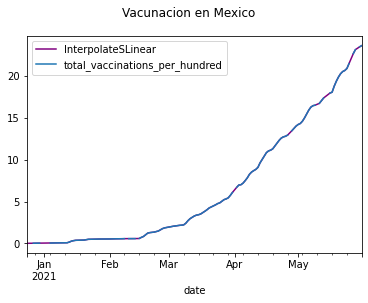

In [ ]:
#distribution
df['InterpolateSLinear'].plot(color='purple')
mexico_vaccinations['total_vaccinations_per_hundred'].plot(subplots=True, figsize=(24, 32), title="Vacunacion en Mexico")
plt.legend(loc='best')
mexico_vaccinations = mexico_vaccinations.assign(total_vaccinations_per_hundred=df['InterpolateSLinear'])

#### Mexico vaccination: people vaccinated per hundred

In [ ]:
#people_vaccinated_per_hundred
# Import a scoring metric to compare methods
df = pd.DataFrame(mexico_vaccinations[['people_vaccinated_per_hundred']])
df = df.assign(FillBackfill = df.people_vaccinated_per_hundred.fillna(value=None, method='backfill', axis=None, limit=None, downcast=None))
df = df.assign(FillFfil = df.people_vaccinated_per_hundred.fillna(method='ffill'))
#mean & median
df = df.assign(FillMean=df.people_vaccinated_per_hundred.fillna(df.people_vaccinated_per_hundred.mean()))
df = df.assign(FillMedian=df.people_vaccinated_per_hundred.fillna(df.people_vaccinated_per_hundred.median()))
# imputing using the rolling average and median
df = df.assign(RollingMean=df.people_vaccinated_per_hundred.fillna(df.people_vaccinated_per_hundred.rolling(24,min_periods=1,).mean()))
df = df.assign(RollingMedian=df.people_vaccinated_per_hundred.fillna(df.people_vaccinated_per_hundred.rolling(24,min_periods=1,).median()))# imputing using the median
#differents types of interpolation
df = df.assign(InterpolateLinear=df.people_vaccinated_per_hundred.interpolate(method='linear'))
df = df.assign(InterpolateTime=df.people_vaccinated_per_hundred.interpolate(method='time'))
df = df.assign(InterpolateQuadratic=df.people_vaccinated_per_hundred.interpolate(method='quadratic'))
df = df.assign(InterpolateCubic=df.people_vaccinated_per_hundred.interpolate(method='cubic'))
df = df.assign(InterpolateSLinear=df.people_vaccinated_per_hundred.interpolate(method='slinear'))
df = df.assign(InterpolateSpline3=df.people_vaccinated_per_hundred.interpolate(method='spline', order=3))
df = df.assign(InterpolateSpline4=df.people_vaccinated_per_hundred.interpolate(method='spline', order=4))
df = df.assign(InterpolateSpline5=df.people_vaccinated_per_hundred.interpolate(method='spline', order=5))
df

,people_vaccinated_per_hundred,FillBackfill,FillFfil,FillMean,FillMedian,RollingMean,RollingMedian,InterpolateLinear,InterpolateTime,InterpolateQuadratic,InterpolateCubic,InterpolateSLinear,InterpolateSpline3,InterpolateSpline4,InterpolateSpline5
date,,,,,,,,,,,,,,,
2020-12-24,0.00,0.00,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-12-25,NaN,0.01,0.00,4.842148,2.80,0.000000,0.00,0.003333,0.003333,0.004966,0.003623,0.003333,0.574617,0.351036,-0.681944
2020-12-26,NaN,0.01,0.00,4.842148,2.80,0.000000,0.00,0.006667,0.006667,0.008299,0.007416,0.006667,0.523367,0.326165,-0.514002
2020-12-27,0.01,0.01,0.01,0.010000,0.01,0.010000,0.01,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000
2020-12-28,0.01,0.01,0.01,0.010000,0.01,0.010000,0.01,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-27,16.07,16.07,16.07,16.070000,16.07,16.070000,16.07,16.070000,16.070000,16.070000,16.070000,16.070000,16.070000,16.070000,16.070000
2021-05-28,16.49,16.49,16.49,16.490000,16.49,16.490000,16.49,16.490000,16.490000,16.490000,16.490000,16.490000,16.490000,16.490000,16.490000
2021-05-29,NaN,16.78,16.49,4.842148,2.80,12.888947,12.54,16.635000,16.635000,16.687041,16.694631,16.635000,15.617238,15.461110,16.174127


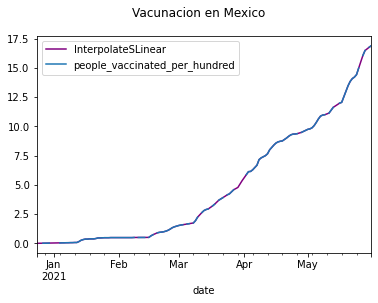

In [ ]:
#distribution
df['InterpolateSLinear'].plot(color='purple')
mexico_vaccinations['people_vaccinated_per_hundred'].plot(subplots=True, figsize=(24, 32), title="Vacunacion en Mexico")
plt.legend(loc='best')
mexico_vaccinations = mexico_vaccinations.assign(people_vaccinated_per_hundred=df['InterpolateSLinear'])

#### Mexico vaccination: people fully vaccinated per hundred

In [ ]:
#people_fully_vaccinated_per_hundred
# Import a scoring metric to compare methods
df = pd.DataFrame(mexico_vaccinations[['people_fully_vaccinated_per_hundred']])
df = df.assign(FillBackfill = df.people_fully_vaccinated_per_hundred.fillna(value=None, method='backfill', axis=None, limit=None, downcast=None))
df = df.assign(FillFfil = df.people_fully_vaccinated_per_hundred.fillna(method='ffill'))
#mean & median
df = df.assign(FillMean=df.people_fully_vaccinated_per_hundred.fillna(df.people_fully_vaccinated_per_hundred.mean()))
df = df.assign(FillMedian=df.people_fully_vaccinated_per_hundred.fillna(df.people_fully_vaccinated_per_hundred.median()))
# imputing using the rolling average and median
df = df.assign(RollingMean=df.people_fully_vaccinated_per_hundred.fillna(df.people_fully_vaccinated_per_hundred.rolling(24,min_periods=1,).mean()))
df = df.assign(RollingMedian=df.people_fully_vaccinated_per_hundred.fillna(df.people_fully_vaccinated_per_hundred.rolling(24,min_periods=1,).median()))# imputing using the median
#differents types of interpolation
df = df.assign(InterpolateLinear=df.people_fully_vaccinated_per_hundred.interpolate(method='linear'))
df = df.assign(InterpolateTime=df.people_fully_vaccinated_per_hundred.interpolate(method='time'))
df = df.assign(InterpolateQuadratic=df.people_fully_vaccinated_per_hundred.interpolate(method='quadratic'))
df = df.assign(InterpolateCubic=df.people_fully_vaccinated_per_hundred.interpolate(method='cubic'))
df = df.assign(InterpolateSLinear=df.people_fully_vaccinated_per_hundred.interpolate(method='slinear'))
df = df.assign(InterpolateSpline3=df.people_fully_vaccinated_per_hundred.interpolate(method='spline', order=3))
df = df.assign(InterpolateSpline4=df.people_fully_vaccinated_per_hundred.interpolate(method='spline', order=4))
df = df.assign(InterpolateSpline5=df.people_fully_vaccinated_per_hundred.interpolate(method='spline', order=5))
df

,people_fully_vaccinated_per_hundred,FillBackfill,FillFfil,FillMean,FillMedian,RollingMean,RollingMedian,InterpolateLinear,InterpolateTime,InterpolateQuadratic,InterpolateCubic,InterpolateSLinear,InterpolateSpline3,InterpolateSpline4,InterpolateSpline5
date,,,,,,,,,,,,,,,
2020-12-24,NaN,0.00,NaN,2.538983,0.585,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-25,NaN,0.00,NaN,2.538983,0.585,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-26,NaN,0.00,NaN,2.538983,0.585,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-27,NaN,0.00,NaN,2.538983,0.585,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-28,NaN,0.00,NaN,2.538983,0.585,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-27,9.47,9.47,9.47,9.470000,9.470,9.470000,9.47,9.470,9.470,9.470000,9.470000,9.470,9.470000,9.470000,9.470000
2021-05-28,9.56,9.56,9.56,9.560000,9.560,9.560000,9.56,9.560,9.560,9.560000,9.560000,9.560,9.560000,9.560000,9.560000
2021-05-29,NaN,9.61,9.56,2.538983,0.585,8.398947,8.63,9.585,9.585,9.597266,9.598358,9.585,10.741703,9.909635,9.345508


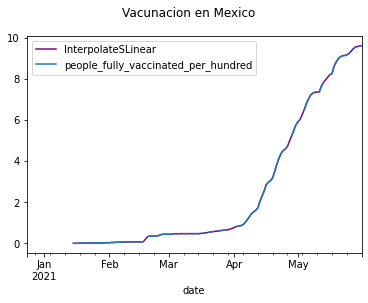

In [ ]:
#distribution
df['InterpolateSLinear'].plot(color='purple')
mexico_vaccinations['people_fully_vaccinated_per_hundred'].plot(subplots=True, figsize=(24, 32), title="Vacunacion en Mexico")
plt.legend(loc='best')
mexico_vaccinations = mexico_vaccinations.assign(people_fully_vaccinated_per_hundred=df['InterpolateSLinear'])

### Mexico vaccination: Clean data

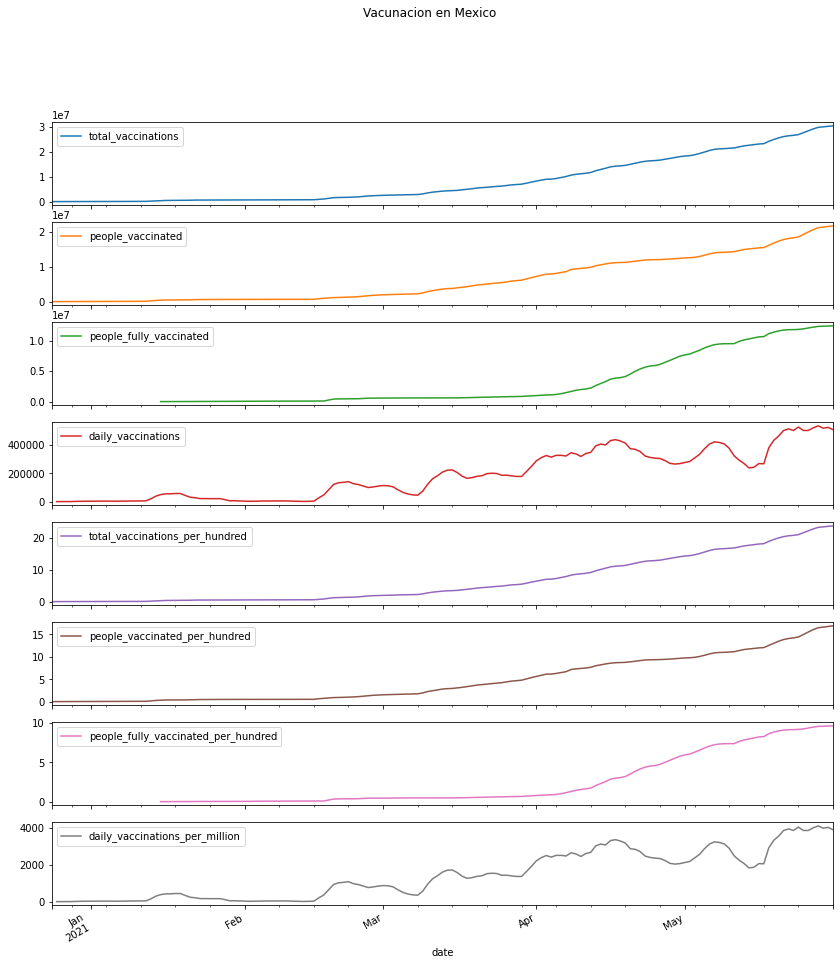

In [ ]:
#distribution
mexico_vaccinations.plot(subplots=True, figsize=(14, 16), title="Vacunacion en Mexico")
plt.legend(loc='best')

### Predictions: Mexico


In [ ]:
#first date with fully vaccinated in Mexico
startDate = mexico_vaccinations['people_fully_vaccinated'].first_valid_index() 
mexico_fully_vaccinated = mexico_vaccinations['people_fully_vaccinated'][startDate:]

In [ ]:
#split data in range of dates, 70% train
steps = 30
data_train = mexico_fully_vaccinated[:-steps]
data_train = data_train
data_test = mexico_fully_vaccinated[-steps:]
data_test = data_test

#### Forecasting autoregresivo: Multiples regression


In [ ]:
# Crear y entrenar forecaster
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')
regressors = [SVR(),
              LinearSVR(random_state=123),
              Ridge(alpha=1.0, random_state=123),
              Lasso(alpha=0.5),
              RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]),
              LassoCV(alphas=[1e-3, 1e-2, 1e-1, 1]),
              LinearSVR(),
              LinearRegression()]

best_error = float('inf')
best_regression = ""
#Find best model
for regressor in regressors:
  forecaster_rf = ForecasterAutoreg(
                      regressor=regressor,
                      lags=15 #remplazado en e grid search
                  )
  forecaster_rf.fit(y=data_train)
  predicciones = forecaster_rf.predict(steps=steps)
  predicciones = pd.Series(data=predicciones, index=data_test.index)
  error_mse = metrics.mean_squared_error(
                y_true = data_test,
                y_pred = predicciones
            )
  
  if(error_mse<best_error):
    best_error = error_mse
    best_regression=regressor
print("Best regression:", best_regression)

Best regression: LassoCV(alphas=[0.001, 0.01, 0.1, 1])


In [ ]:
#Try with the best regression

forecaster_rf = ForecasterAutoreg(
                      regressor=best_regression,
                      lags=15 #remplazado en e grid search
                  )
forecaster_rf.fit(y=data_train)
predicciones = forecaster_rf.predict(steps=steps)
predicciones = pd.Series(data=predicciones, index=data_test.index)
error_mse = metrics.mean_squared_error(
              y_true = data_test,
              y_pred = predicciones
          )
print(f"Error de test (mse): {error_mse}")
print('Mean Absolute Error:', metrics.mean_absolute_error(data_test, predicciones)) 

Error de test (mse): 58855086696481.59
Mean Absolute Error: 5480745.094540271


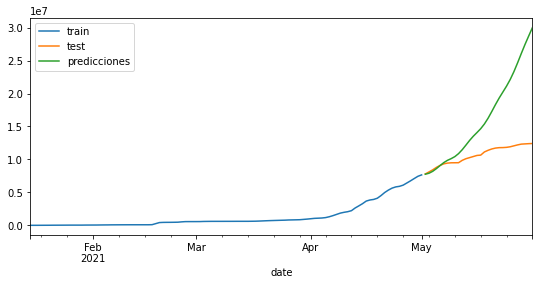

In [ ]:
fig, ax = plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend()

#### AUTO-SARIMAX model: Mexico vaccination

#### Train AUTO-SARIMAX model

In [ ]:
#Find best order
model = pm.auto_arima(data_train, start_p=0, start_q=0)
best_order = model.get_params()['order']
best_seasonal_order = model.get_params()['seasonal_order']
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  107
Model:               SARIMAX(4, 2, 2)   Log Likelihood               -1262.683
Date:                Mon, 14 Jun 2021   AIC                           2539.367
Time:                        20:03:07   BIC                           2557.944
Sample:                             0   HQIC                          2546.895
                                - 107                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8065      0.123      6.543      0.000       0.565       1.048
ar.L2         -1.0160      0.141     -7.192      0.000      -1.293      -0.739
ar.L3          0.3028      0.121      2.499      0.012       0.065       0.540
ar.L4         -0.5625      0.101     -5.588      0.000      -0.760      -0.365
ma.L1         -0.9020      0.151     -5.989      0.000      -1.197      -0.607
ma.L2          0.5465      0.149      3.674      0.000       0.255       0.838
sigma2      1.823e+09   9.11e-11      2e+19      0.000    1.82e+09    1.82e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):               599.09
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               5.32   Skew:                             2.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.06e+35. Standard errors may be unstable.
"""

In [ ]:
#ARIMA with best order
model = sm.tsa.statespace.SARIMAX(data_train, order=best_order, seasonal_order=best_seasonal_order)
model_fit = model.fit(disp=False)

In [ ]:
#Predict how many days to the future.
def forecast_to_df(model, steps):
    forecast = model.get_forecast(steps=steps)
    pred_df = forecast.conf_int()
    pred_df['pred'] = forecast.predicted_mean
    pred_df.columns = ['lower', 'upper', 'pred']
    return pred_df

pred_df = forecast_to_df(model_fit, steps = len(data_test))

(<Figure size 864x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9d0020e390>)

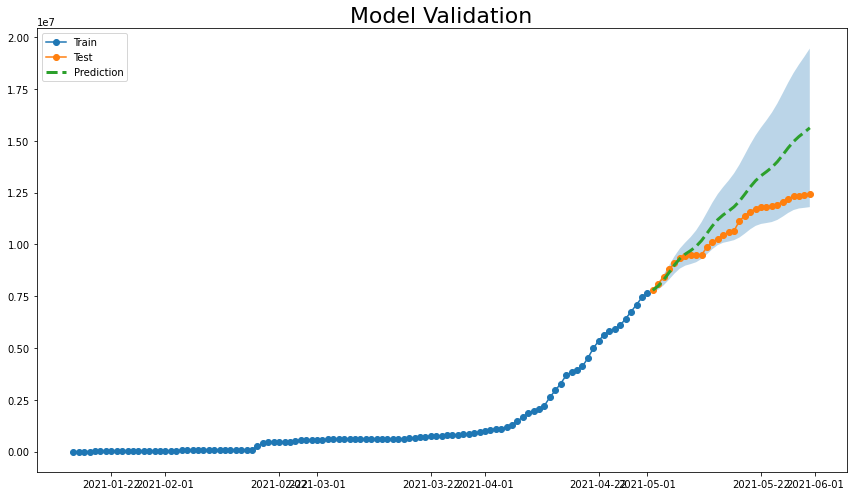

In [ ]:
#Plot function
def plot_train_test_pred(train,test,pred_df):
    fig,ax = plt.subplots(figsize=(12,7))
    kws = dict(marker='o')
    
    ax.plot(train,label='Train',**kws)
    ax.plot(test,label='Test',**kws)
    ax.plot(pred_df['pred'],label='Prediction',ls='--',linewidth=3)

    ax.fill_between(x=pred_df.index,y1=pred_df['lower'],y2=pred_df['upper'],alpha=0.3)
    ax.set_title('Model Validation', fontsize=22)
    ax.legend(loc='upper left')
    fig.tight_layout()
    return fig,ax
plot_train_test_pred(data_train, data_test, pred_df)

In [ ]:
error_mse = metrics.mean_squared_error(pred_df['pred'], data_test)
print(f"Error de test (mse): {error_mse}")
print('Mean Absolute Error:', metrics.mean_absolute_error(data_test, pred_df['pred'])) 

Error de test (mse): 2328261250492.389
Mean Absolute Error: 1185238.674221906


#### Predict with best model

In [ ]:
#Train model with all the data with the best parms
model = sm.tsa.statespace.SARIMAX(mexico_fully_vaccinated,order=best_order, seasonal_order=best_seasonal_order).fit()

In [ ]:
#Population in Mexico
MEXICO_POPULATION = 128970000 #INEGI 2021
# MEXICO_POPULATION = country_population[country_population['Country Name']=="México"]['2019'].values
MEXICO_70_PERCENT = MEXICO_POPULATION*0.7 
count = 0
i = 1
while (MEXICO_70_PERCENT-count)>0:
  pred_df = forecast_to_df(model, steps = i)
  count = pred_df.pred[-1]
  i+=1
days_until = i-1

(<Figure size 864x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9cffc80350>)

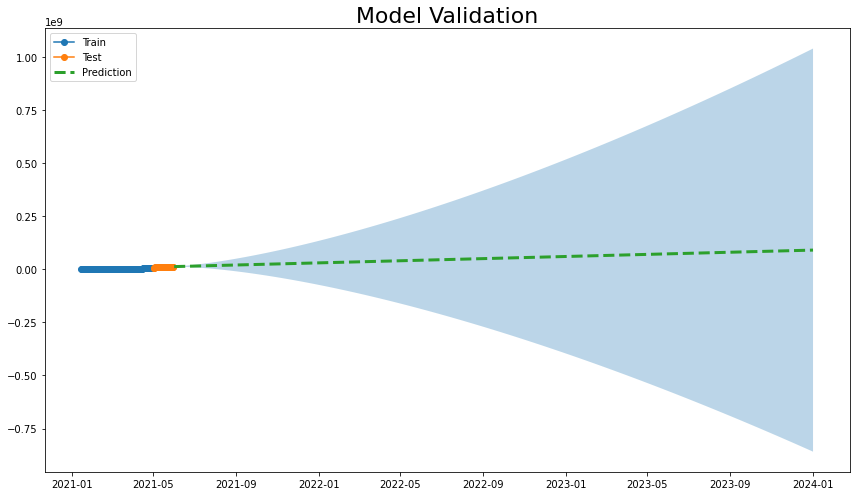

In [ ]:
mexico_pred_df = forecast_to_df(model, steps = days_until)
plot_train_test_pred(data_train, data_test, mexico_pred_df)

In [ ]:
print("Days until fully vaccinated in Mexico:", days_until)
print("Date fully vaccinated in Mexico", startDate+timedelta(days=days_until))

Days until fully vaccinated in Mexico: 945
Date fully vaccinated in Mexico 2023-08-18 00:00:00


## LatinoAmerica vaccination

### Clean data with linearInterpolation

In [ ]:
#Fix names in country population
country_population = country_population.replace("Brasil", "Brazil")
country_population = country_population.replace("Perú", "Peru")

In [ ]:
latinoamerica_countries = ['Argentina', 'Aruba','Bolivia', 'Brazil', 'Chile', 'Colombia', 'Costa Rica', 'Peru', "Ecuador"]
latinoamerica_dfs = {}
for country in latinoamerica_countries:
  latinoamerica_dfs[country] = (country_vaccinations[country_vaccinations['country']==country])
  latinoamerica_dfs[country]['date'] = pd.to_datetime(latinoamerica_dfs[country]['date'])
  latinoamerica_dfs[country].set_index('date', inplace=True)
  #Clean data
  df = pd.DataFrame(latinoamerica_dfs[country][['people_fully_vaccinated']])
  df = df.assign(InterpolateSLinear=df.people_fully_vaccinated.interpolate(method='slinear'))
  #plot clean data
  # df['InterpolateSLinear'].plot(color='purple')
  # latinoamerica_dfs[country]['people_fully_vaccinated'].plot(figsize=(12, 12), title="Vacunacion en "+country)
  # plt.legend(loc='best')
  latinoamerica_dfs[country] = latinoamerica_dfs[country].assign(people_fully_vaccinated=df['InterpolateSLinear'])
  # plt.show()

### AUTO-SARIMAX model

In [ ]:
res_preditions = {} #Save predictions
for country in latinoamerica_countries:
  #first date with fully vaccinated in Mexico
  startDate = latinoamerica_dfs[country]['people_fully_vaccinated'].first_valid_index() 
  if(startDate is not None):
    latinoamerica_dfs[country] = latinoamerica_dfs[country][startDate:]
    #Get best parms for ARIMA model
    model = pm.auto_arima(data_train, start_p=0, start_q=0)
    best_order = model.get_params()['order']
    best_seasonal_order = model.get_params()['seasonal_order']
    #Train model with all the data with the best parms
    model = sm.tsa.statespace.SARIMAX(latinoamerica_dfs[country]['people_fully_vaccinated'],order=best_order, seasonal_order=best_seasonal_order).fit()
    #Population in Mexico
    population = country_population[country_population['Country Name']==country]['2019'].values
    population_70_percent = population*0.7 
    count = 0
    i = 1
    while (population_70_percent-count)>0:
      pred_df = forecast_to_df(model, steps = i)
      count = pred_df.pred[-1]
      i+=1
    days_until = i-1
    res_preditions[country] = pred_df['pred']
    print(country, days_until, startDate+timedelta(days=days_until))

Argentina 578 2022-08-21 00:00:00
Aruba 76 2021-06-13 00:00:00
Bolivia 2017 2026-09-09 00:00:00
Brazil 468 2022-05-20 00:00:00
Chile 181 2021-07-13 00:00:00
Colombia 2030 2026-10-03 00:00:00
Costa Rica 360 2022-01-10 00:00:00
Peru 1032 2023-12-29 00:00:00
Ecuador 471 2022-06-03 00:00:00


In [ ]:
import plotly.express as px

res_preditions['Mexico'] = mexico_pred_df['pred'] #append Mexico to predict list
latinoamerica_countries.append("Mexico")
df_plot = pd.DataFrame()

for country in latinoamerica_countries:
  df_row = res_preditions[country].to_frame()
  df_row = df_row.assign(countryName=country)
  df_plot = df_plot.append(df_row)

fig = px.line(df_plot, x=df_plot.index, y="pred", color="countryName", title="LatinoAmerica vaccination")
fig.show()